In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
from sklearn.impute import KNNImputer

In [461]:
from sklearn.preprocessing import LabelEncoder,StandardScaler

In [463]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from  xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import GridSearchCV
import os

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
## Reading the Input training data:
df_sal=pd.read_csv('train.csv')

In [4]:
print('Total values',df_sal.shape)

Total values (8523, 12)


In [19]:
df_sal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [20]:
df_sal.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [5]:
## Null values for each columns:
df_sal.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Only Two columns has Null values need to handle them. In which one is categorical feature and another one is numerical feature

Mean- 12.857645184135976
Median- 12.6
Mode- 0    12.15
Name: Item_Weight, dtype: float64
Standard Deviation- 4.643456499186395


C:\Users\Balaji Ramakrishnan\AppData\Local\Temp\ipykernel_13192\3835988780.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_sal['Item_Weight'])
C:\Users\Balaji Ramakrishnan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


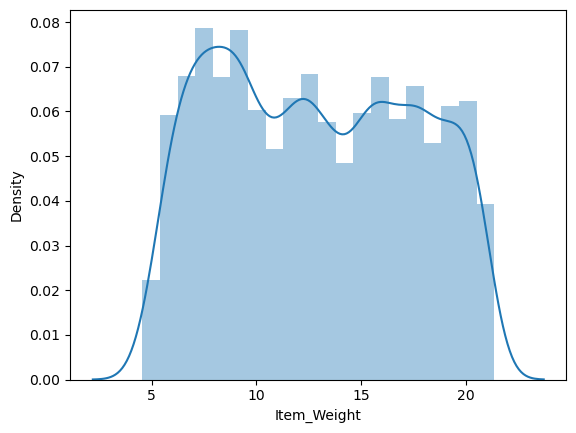

In [18]:
# df_sal['Outlet_Size']
## Item Weight will say the weigh of each product
sns.distplot(df_sal['Item_Weight'])
# sns.kdeplot(df_sal['Item_Weight'])
print('Mean-',df_sal['Item_Weight'].mean())
print('Median-',df_sal['Item_Weight'].median())
print('Mode-',df_sal['Item_Weight'].mode())
print('Standard Deviation-',df_sal['Item_Weight'].std())

When I look into the data, It seems data is been dispersed very well and value will be ranging between 4-22 aprx.

Standart Deviation- 4.2261237245329735
Standart Deviation- 4.227240406467719
Standart Deviation- 4.2345404209745565


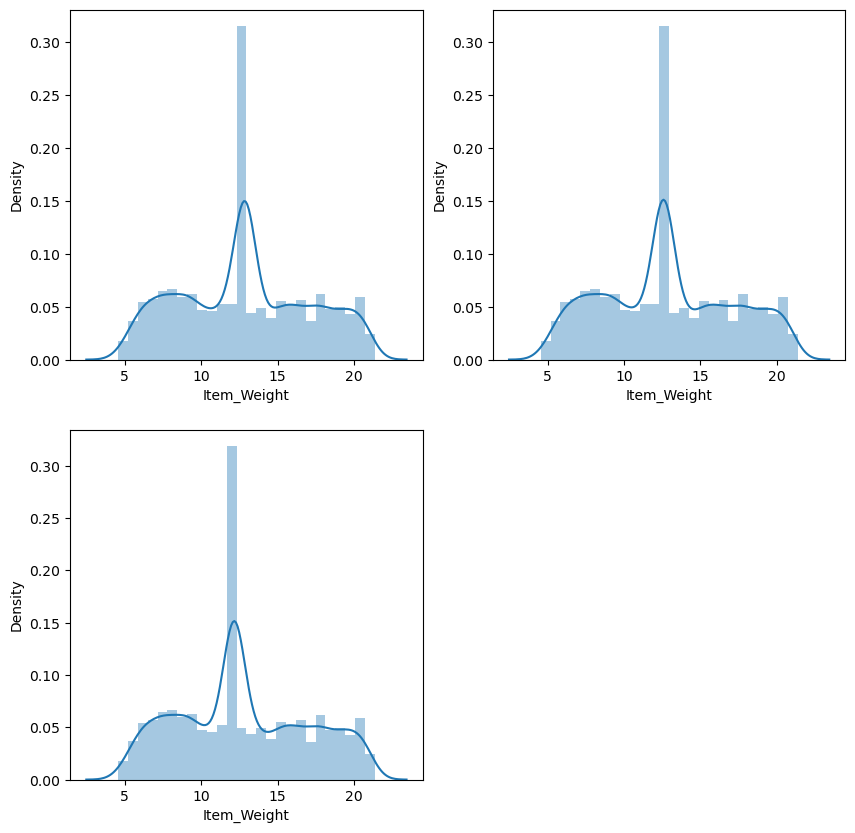

In [31]:
plt.figure(figsize=(10,10))
mean=df_sal['Item_Weight'].mean()
median=df_sal['Item_Weight'].median()
mode=df_sal['Item_Weight'].mode()[0]
check=[mean,median,mode]
for i in range(1,4):
    axe=plt.subplot(2,2,i)
    print('Standart Deviation-',df_sal['Item_Weight'].fillna(value=check[i-1]).std())
    sns.distplot(df_sal['Item_Weight'].fillna(value=check[i-1]),ax=axe)
    

Data is been skewed and one partiicular value spike has been created.

In [118]:
# df_sal.loc[df_sal['Item_Weight'].isnull()==False,'Item_Weight'].sample(df_sal['Item_Weight'].isnull().sum())
null_index=df_sal[df_sal['Item_Weight'].isnull()==True].index
replace_values=df_sal.loc[df_sal['Item_Weight'].isnull()==False,'Item_Weight'].sample(df_sal['Item_Weight'].isnull().sum())
replace_values.index=null_index
df_sal['Item_Weight'].fillna(replace_values,inplace=True)
print('Standard Deviation: ',df_sal['Item_Weight'].std())

Standard Deviation:  4.641354441982182


As Notice above if I use Mean/Median/Mode technique. Overall data has been dispersed. So now, I have useed the sampling technique
to handle the NULL value

Test Data Sample

In [753]:
def NULL_handling(test_df,cn):
    # df_sal.loc[df_sal['Item_Weight'].isnull()==False,'Item_Weight'].sample(df_sal['Item_Weight'].isnull().sum())
    null_index=test_df[test_df[cn].isnull()==True].index
    replace_values=test_df.loc[test_df[cn].isnull()==False,cn].sample(test_df[cn].isnull().sum())
    replace_values.index=null_index
    test_df[cn].fillna(replace_values,inplace=True)
    print('Standard Deviation: ',test_df[cn].std())
    return test_df
    

<Axes: xlabel='Item_Weight', ylabel='Density'>

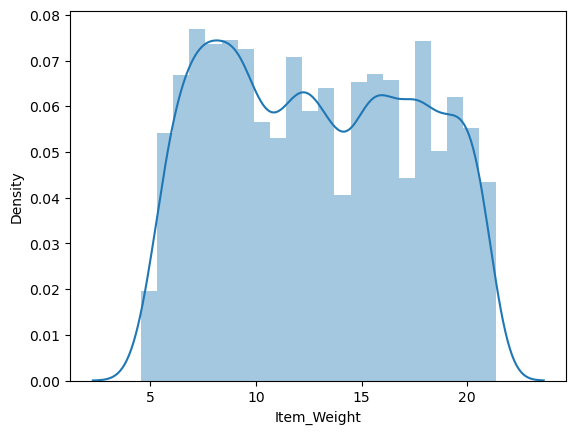

In [121]:
sns.distplot(df_sal['Item_Weight'])

 Since Mean/Median/Mode distortes the original distribution and increase the count of the same values to all the feature. 
 I have used 'sample Imputaion technique' where the SD is not changed much and the distribution of the variable is not impacted.

<Axes: xlabel='Outlet_Size'>

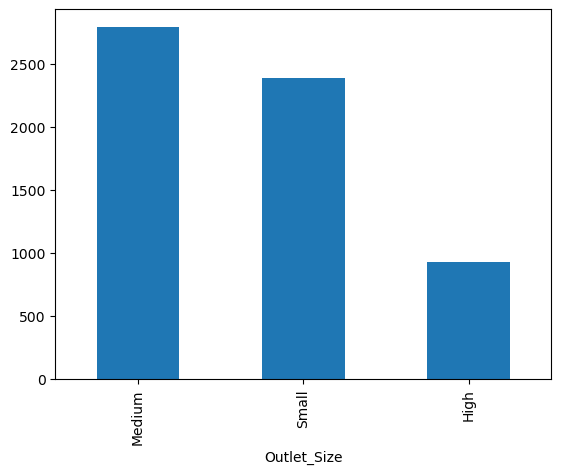

In [151]:
df_sal['Outlet_Size'].value_counts().plot.bar()

As per the above diagram most of the outlet size is medium. So If we handle the value the NA using 'Count/ frequency' it 
data will get skewed or biased to one feature.

<Axes: xlabel='Outlet_Size', ylabel='count'>

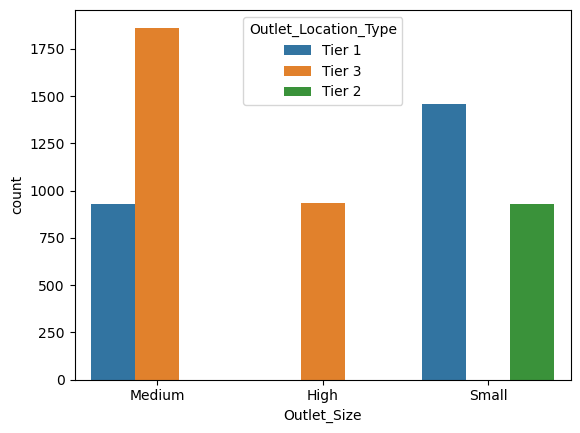

In [141]:
sns.countplot(data=df_sal,x='Outlet_Size',hue='Outlet_Location_Type')

<Axes: xlabel='Outlet_Location_Type'>

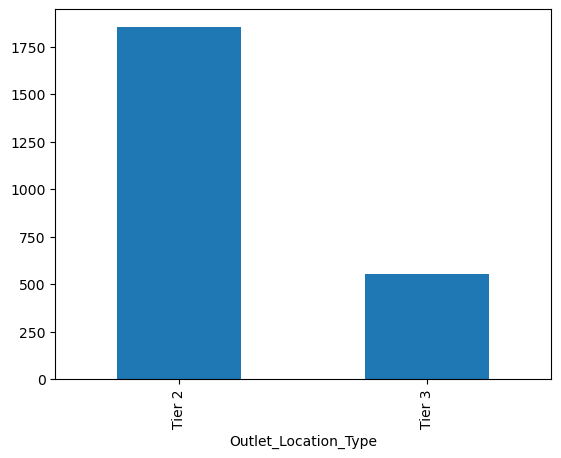

In [169]:
df_sal.loc[df_sal['Outlet_Size'].isnull()==True,'Outlet_Location_Type'].value_counts().plot.bar()

As we can see from the above diagrams that mostly, missing data is only for the outlet present in 'Tier 3 and Tier 2' locations.
so, Also, for all the outlet present in Tier 2 location are small and around 20% of missing values belongs to tier 2 only
and Tier 3 is falling under medium or High. In order to balace will replace the tier 3 records with High

In [182]:
df_sal['Outlet_Size']=df_sal[['Outlet_Size','Outlet_Location_Type']].apply(lambda x: 'Small' if (pd.isna(x['Outlet_Size'])==True) 
                                                     & (x['Outlet_Location_Type']=='Tier 2') else ( 'High' if (pd.isna(x['Outlet_Size'])==True) & (x['Outlet_Location_Type']!='Tier 2') else x['Outlet_Size']),axis=1)

<Axes: xlabel='Outlet_Size', ylabel='count'>

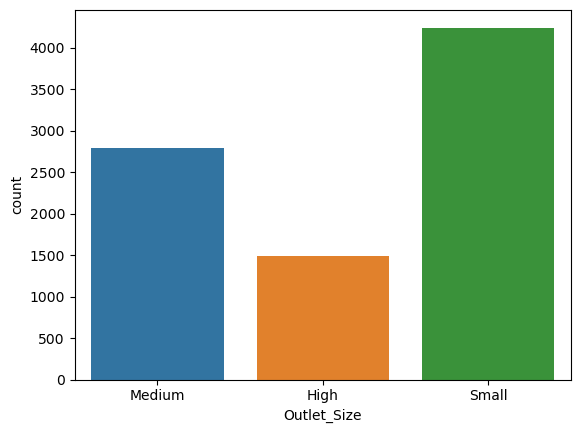

In [186]:
sns.countplot(data=df_sal,x='Outlet_Size')

As per the above diagram most of the outlet size is Small. But it make sense as per the data

<Axes: xlabel='Outlet_Establishment_Year,Outlet_Identifier'>

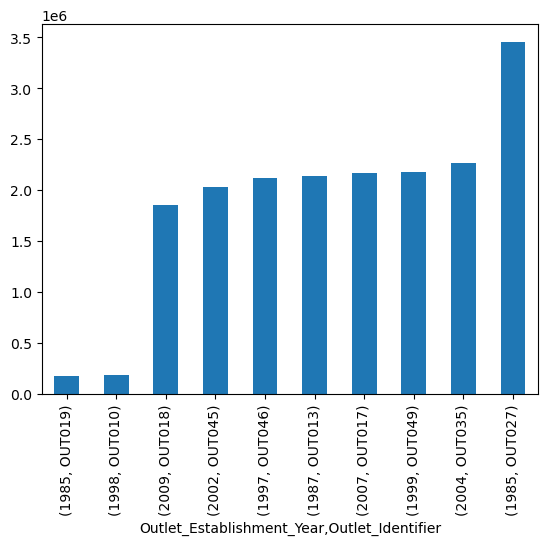

In [224]:
df_sal.groupby(['Outlet_Establishment_Year','Outlet_Identifier'])['Item_Outlet_Sales'].sum().sort_values().plot.bar()

<Axes: xlabel='Outlet_Establishment_Year'>

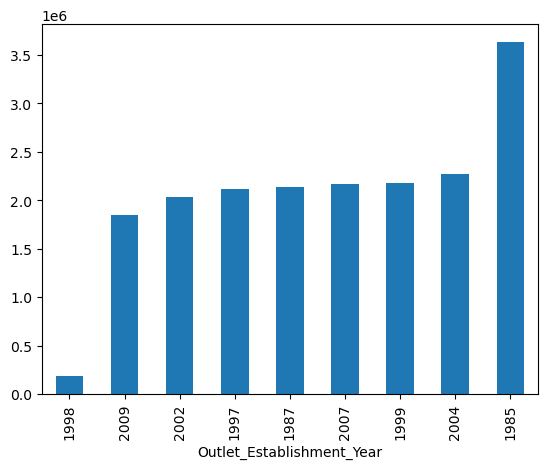

In [221]:
df_sal.groupby(['Outlet_Establishment_Year'])['Item_Outlet_Sales'].sum().sort_values().plot.bar()

As per the above view sales is very good in 1985 particularly for the outlet 'Outlet027'.

In [209]:
df_sal.loc[:,['Outlet_Identifier','Outlet_Establishment_Year']].drop_duplicates().sort_values(by='Outlet_Establishment_Year')

,Outlet_Identifier,Outlet_Establishment_Year
7,OUT027,1985
23,OUT019,1985
4,OUT013,1987
11,OUT046,1997
3,OUT010,1998
0,OUT049,1999
8,OUT045,2002
19,OUT035,2004
9,OUT017,2007
1,OUT018,2009


We have around 10 outlets and noticed there is no interval or year gaps in opening all these outlet and based on the data give it shown all
the shop opening has been happened based on other market field analysis not based on the  year interval or every year one show is been 
opened. since there is not pattern. Dropping this 'Outlet_Establishment_Year' feature.

<Axes: xlabel='Outlet_Type'>

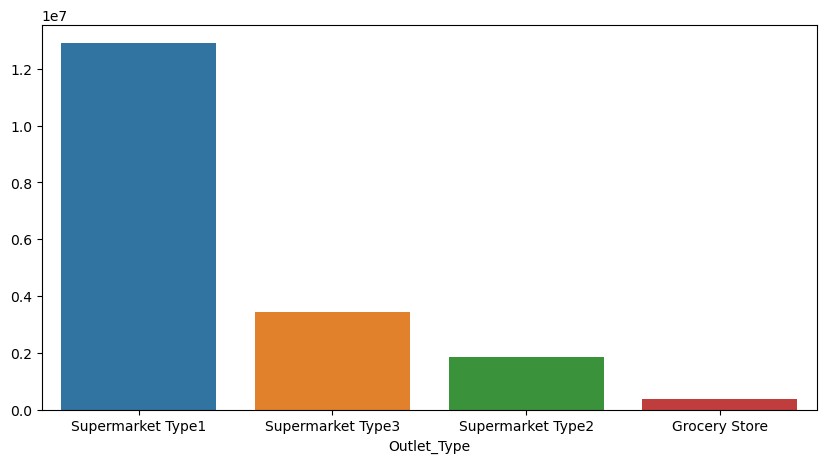

In [244]:
fig=plt.figure(figsize=(10,5))
outlet_group=df_sal.groupby('Outlet_Type') ['Item_Outlet_Sales'].sum().sort_values(ascending=False)
sns.barplot(x=outlet_group.index,y=outlet_group.values)

Sale is Good at supermarket Type 1

<Axes: xlabel='Outlet_Location_Type', ylabel='Item_Outlet_Sales'>

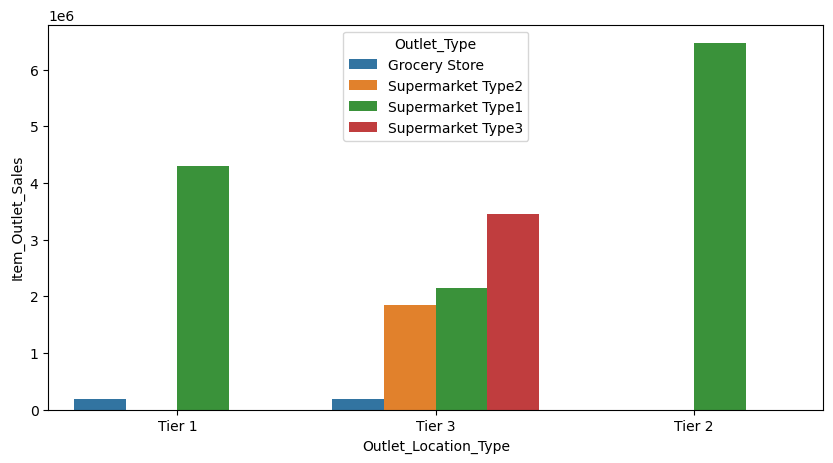

In [258]:
fig=plt.figure(figsize=(10,5))
outlet_with_loc=df_sal.groupby(['Outlet_Type','Outlet_Location_Type'],as_index=False)['Item_Outlet_Sales'].sum().sort_values(by='Item_Outlet_Sales')
sns.barplot(data=outlet_with_loc,x='Outlet_Location_Type',y='Item_Outlet_Sales',hue='Outlet_Type')

1.Tier 3 has all type of outler types
2. Supeermarket Type 2 is been opened in all the tier's

In [283]:
Item_type=df_sal.groupby(['Item_Type'],as_index=False)['Item_Identifier'].count().sort_values(by='Item_Identifier',ascending=False)

<Axes: xlabel='Item_Type', ylabel='Item_Identifier'>

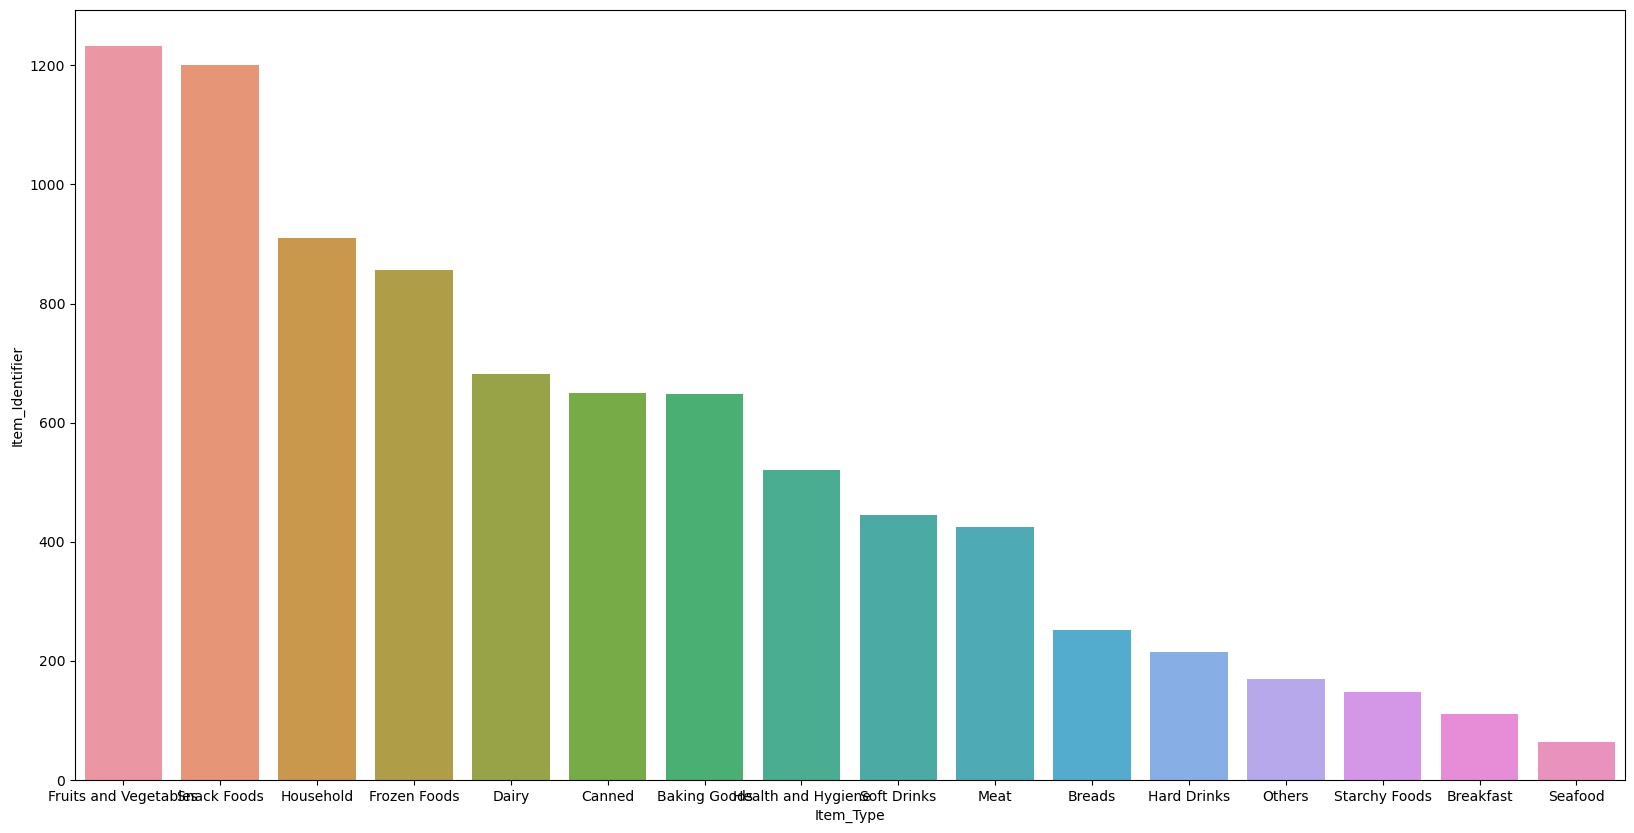

In [284]:
plt.figure(figsize=(20,10))
sns.barplot(data=Item_type,x='Item_Type',y='Item_Identifier')

Fruits & Vegetables & Snacks product are more in all the outlets

<Axes: xlabel='Item_Type', ylabel='Item_Outlet_Sales'>

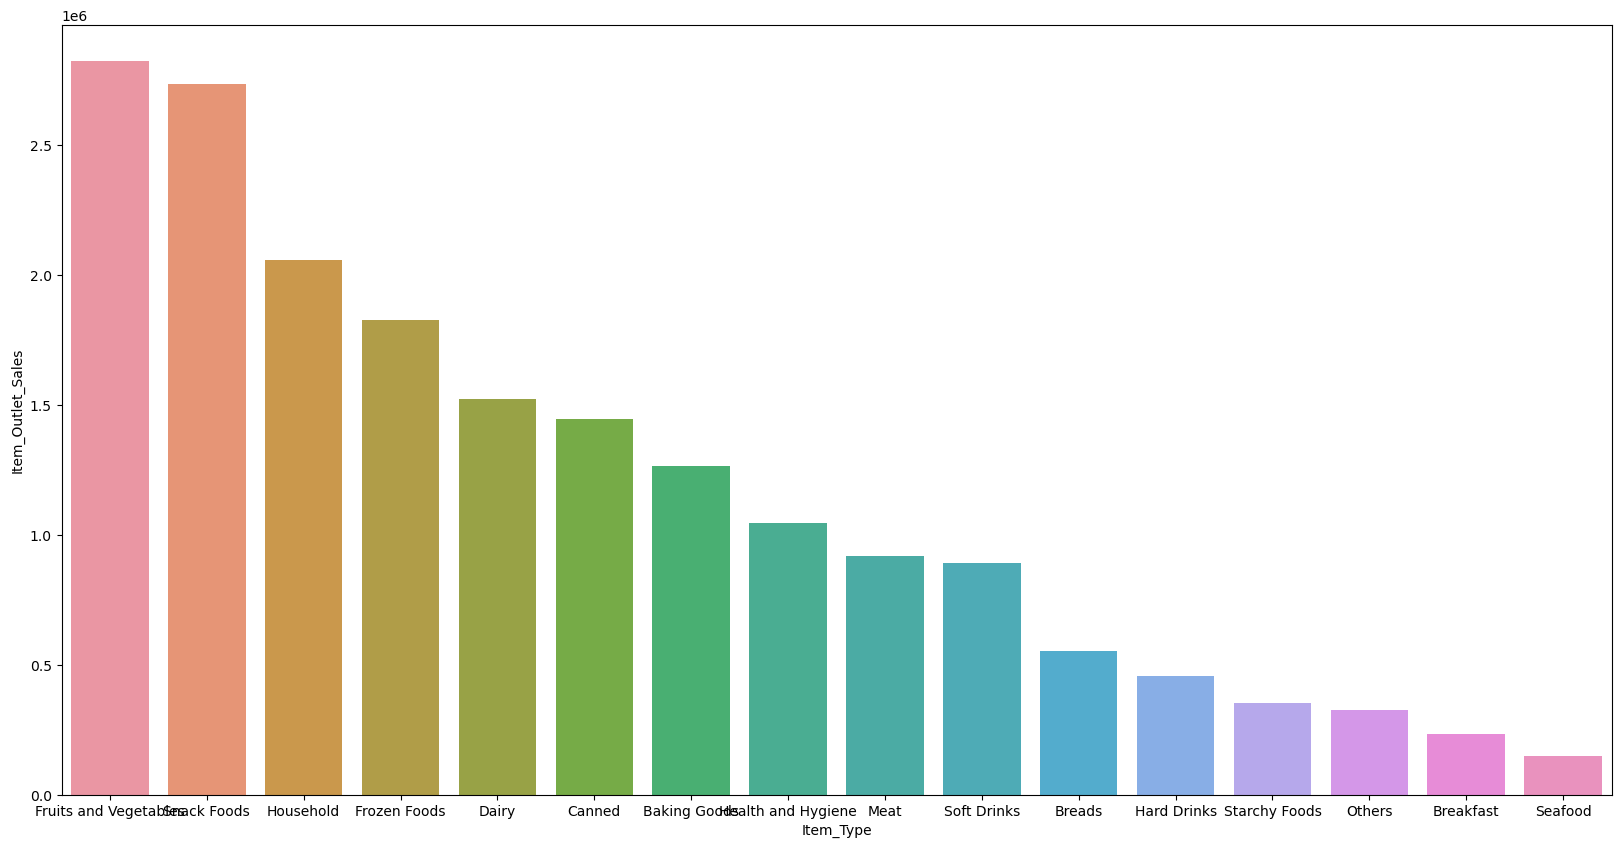

In [294]:
plt.figure(figsize=(20,10))
sale_itemtype=df_sal.groupby('Item_Type',as_index=False)['Item_Outlet_Sales'].sum().sort_values(by='Item_Outlet_Sales',ascending=False)
sns.barplot(data=sale_itemtype,x='Item_Type',y='Item_Outlet_Sales')

There is no change, seems Fruits & Vegetables & Snacks product are sale amount is more whre compate to all the other product type

In [326]:
def percentage_check(value):
    i=float(value*100)
    if i <=5.0:
        return '0-5'
    elif i>5.0 and i<10.0:
        return '5-10'
    elif i>10.0 and i<=20.0:
        return '11-20'
    elif i>20.0 and i<=30:
        return '20-30'
    else:
        return '>30'

In [327]:
df_sal['Item_Visibility_pecrange']=df_sal['Item_Visibility'].apply(lambda x: percentage_check(x))

<Axes: xlabel='Item_Visibility_pecrange', ylabel='count'>

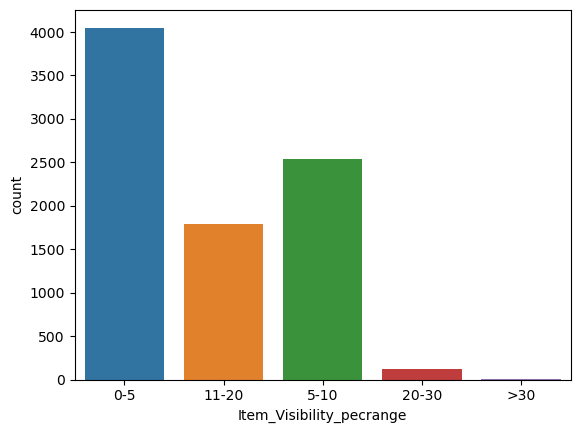

In [328]:
sns.countplot(data=df_sal,x='Item_Visibility_pecrange')

We can see mostly for all the products visiblitly is given between 0-5 and 5-10 pec area

Below are the Products list which occupies 30% of the visibility space

In [332]:
df_sal[df_sal['Item_Visibility_pecrange']=='>30']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Visibility_pecrange
854,FDU13,6.385,low fat,0.328391,Canned,146.0418,OUT019,1985,Small,Tier 1,Grocery Store,588.5672,>30
1805,FDJ56,7.475,Low Fat,0.321115,Fruits and Vegetables,100.7700,OUT019,1985,Small,Tier 1,Grocery Store,199.7400,>30
2251,FDY21,9.195,LF,0.303743,Snack Foods,196.0110,OUT019,1985,Small,Tier 1,Grocery Store,589.2330,>30
2855,NCE31,7.670,Low Fat,0.309390,Household,33.2216,OUT010,1998,High,Tier 3,Grocery Store,138.4864,>30
3474,FDS12,16.000,LF,0.304859,Baking Goods,125.4362,OUT019,1985,Small,Tier 1,Grocery Store,755.0172,>30
3750,NCZ18,5.325,Low Fat,0.325781,Household,252.7698,OUT019,1985,Small,Tier 1,Grocery Store,761.0094,>30
4382,FDG32,9.800,Low Fat,0.308145,Fruits and Vegetables,222.0772,OUT019,1985,Small,Tier 1,Grocery Store,889.5088,>30
5150,FDR14,15.850,Low Fat,0.304737,Dairy,54.7298,OUT019,1985,Small,Tier 1,Grocery Store,107.8596,>30
5732,FDC34,14.100,Regular,0.302479,Snack Foods,155.4972,OUT019,1985,Small,Tier 1,Grocery Store,311.5944,>30
6622,FDI32,12.150,Low Fat,0.305305,Fruits and Vegetables,116.6834,OUT019,1985,Small,Tier 1,Grocery Store,460.7336,>30


In [386]:
categorical_features=[]
for i in df_sal.dtypes[df_sal.dtypes=='object'].index:
    categorical_features.append(i)
    

In [387]:
for i in categorical_features:
    print(i,'-->',df_sal[i].unique())

Item_Identifier --> ['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']
Item_Fat_Content --> ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
Item_Type --> ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
Outlet_Identifier --> ['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
Outlet_Size --> ['Medium' 'High' 'Small']
Outlet_Location_Type --> ['Tier 1' 'Tier 3' 'Tier 2']
Outlet_Type --> ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']
Item_Visibility_pecrange --> ['0-5' '11-20' '5-10' '20-30' '>30']
Item_Identifier_Code --> ['FDA' 'DRC' 'FDN' 'FDX' 'NCD' 'FDP' 'FDO' 'FDH' 'FDU' 'FDY' 'FDS' 'FDF'
 'NCB' 'DRI' 'FDW' 'FDC' 'FDR' 'FDV' 'DRJ' 'FDE' 'NCS' 'DRH' 'NCX' 'DRZ'
 'FDB' 'FDK' 'FDL' 'FDM' 'NCP' 'NCL' 'DRK' 'FDI' 'FDZ' 'NCI' 'FDJ' 'FDG'
 'NCZ' 'FDQ' 'FDD'

In [393]:
## Item_Fat_Content
fat_content_Val={'low fat':'Low Fat','LF':'Low Fat','reg':'Regular'}
df_sal['Item_Fat_Content']=df_sal['Item_Fat_Content'].replace(fat_content_Val)

In [398]:
## Outlet:
df_sal['Outlet_Identifier']=df_sal['Outlet_Identifier'].str.replace('OUT','')

In [367]:
# df_sal['Item_Identifier_Code']=df_sal['Item_Identifier'].apply(lambda x: re.findall('^[A-Z]+',x)[0])

In [380]:
df_sal['Item_Identifier_Code']=df_sal['Item_Identifier'].str.extract('([A-Za-z]+)')
df_sal['Item_Identifier_id']=df_sal[['Item_Identifier','Item_Identifier_Code']].apply(lambda x: x['Item_Identifier'].replace(x['Item_Identifier_Code'],''),axis=1)

Item Identifier Column Handling:
I notice Item_Identifier has Product Code followed by ID. So Instead of making label encode on all the values. I have splitter 
the code and ID into two column and will do label encoding on the code column only.

In [403]:
label_objects={}
for i in ['Item_Fat_Content','Item_Type','Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Identifier_Code']:
    le=LabelEncoder()
    df_sal[i]=le.fit_transform(df_sal[i])
    label_objects[i]=le

In [409]:
## Dropping the unwanted columns:
drop_col=['Item_Identifier','Item_Visibility_pecrange','Outlet_Establishment_Year']
df_sal.drop(drop_col,inplace=True,axis=1)

In [414]:
df_sal=df_sal[['Item_Identifier_Code','Item_Identifier_id','Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type','Item_Outlet_Sales']]

In [ ]:
for i in df_sal.columns:
    if df_sal[i].dtypes=='O':
        print(i)
        df_sal[i]=df_sal[i].apply(lambda x: str(x).strip())


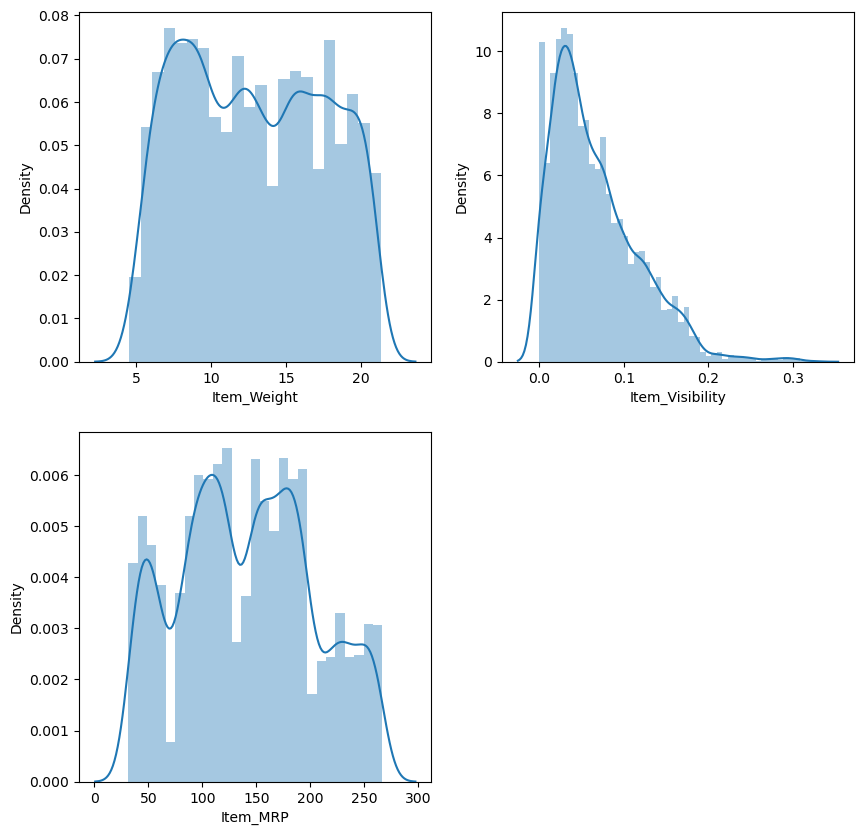

In [426]:
fig=plt.figure(figsize=(10,10))
num_col=['Item_Weight','Item_Visibility','Item_MRP']
p=1
for i in num_col:
    axe=plt.subplot(2,2,p)
    sns.distplot(a=df_sal[i],ax=axe)
    p+=1
# df_sal

Item_Visibility is Right skewed and remaining two column data has been dispersed by there is some distortion in the center

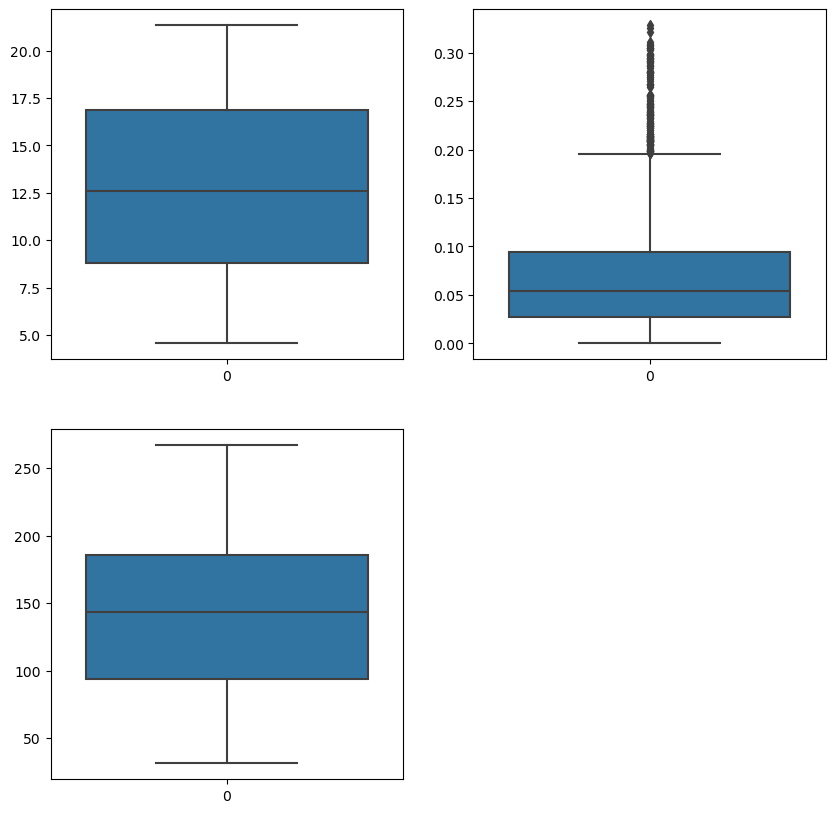

In [430]:
## Outlier Check for the Numerical valiable
fig=plt.figure(figsize=(10,10))
num_col=['Item_Weight','Item_Visibility','Item_MRP']
p=1
for i in num_col:
    axe=plt.subplot(2,2,p)
    sns.boxplot(data=df_sal[i],ax=axe)
    p+=1
# df_sal

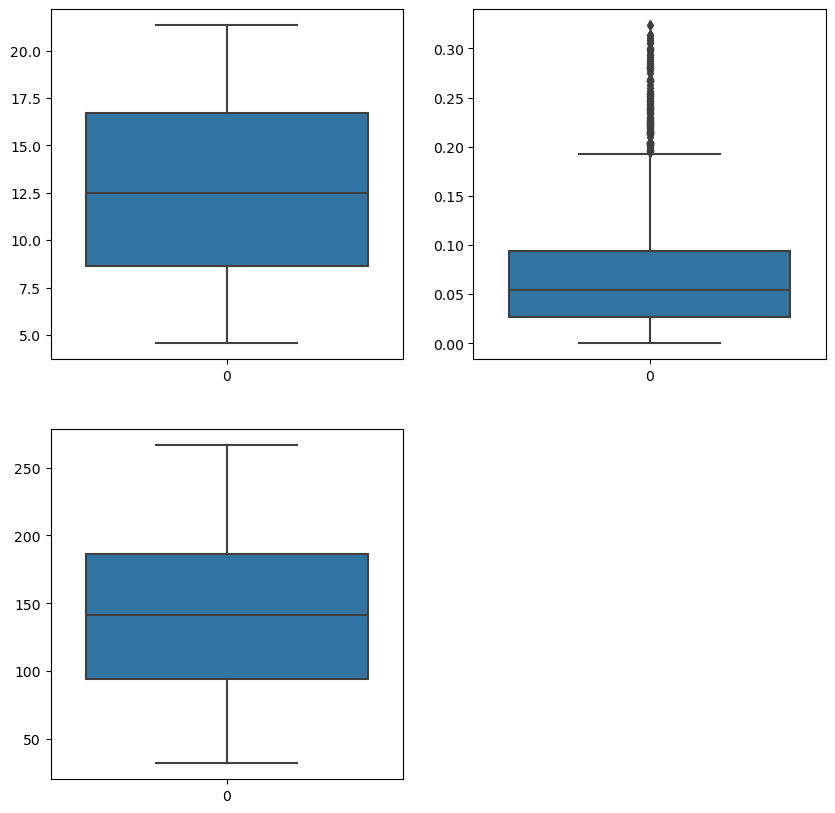

In [577]:
## Outlier Check for the Numerical valiable
fig=plt.figure(figsize=(10,10))
num_col=['Item_Weight','Item_Visibility','Item_MRP']
p=1
for i in num_col:
    axe=plt.subplot(2,2,p)
    sns.boxplot(data=df_sal_test[i],ax=axe)
    p+=1
# df_sal

We don't have outlier for the Item_Weight and Item_MRP. But we have for Item_Visibility that we need to handle it

Creating a Generalized Outlier function to handle the same for test data as well

In [438]:
df_sal_bk=df_sal.copy()

In [579]:
def Outlier_handle(df,col_name):        
    IQR=df[col_name].quantile(0.75)-df[col_name].quantile(0.25)
    min_scale=df[col_name].quantile(0.25)-IQR*1.5
    max_scale=df[col_name].quantile(0.75)+IQR*1.5
    print('IQR: ',IQR)
    print('min_scale: ',min_scale)
    print('max_scale: ',max_scale)
    if (df[col_name]<= min_scale).any() or (df[col_name]>= max_scale).any():
        df.loc[df[col_name]<= min_scale,col_name]=min_scale
        df.loc[df[col_name]>= max_scale,col_name]=max_scale
    

In [456]:
Outlier_handle('Item_Visibility')

IQR:  0.067595815
min_scale:  -0.07440424500000001
max_scale:  0.195979015


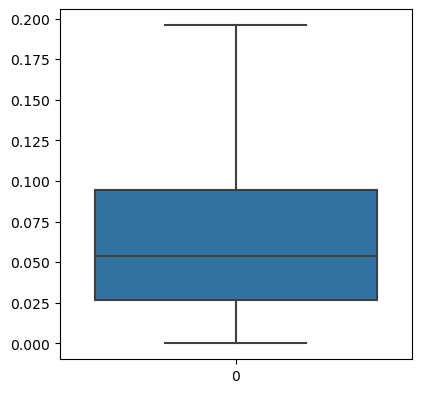

In [459]:
## Outlier Check for the Numerical valiable
fig=plt.figure(figsize=(10,10))
num_col=['Item_Visibility']
p=1
for i in num_col:
    axe=plt.subplot(2,2,p)
    sns.boxplot(data=df_sal[i],ax=axe)
    p+=1
# df_sal

After removing the outliers. Yes data is some what skewed. we can apply some standratization techniques. 

In [499]:
features_lst=['Item_Weight','Item_Visibility','Item_MRP','Item_Outlet_Sales']
df_sal[features_lst].corr()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales
Item_Weight,1.000000,-0.009487,0.021361,0.009487
Item_Visibility,-0.009487,1.000000,-0.001163,-0.117918
Item_MRP,0.021361,-0.001163,1.000000,0.567574
Item_Outlet_Sales,0.009487,-0.117918,0.567574,1.000000


We can see Item visibility has very low corellation with the Output variable

In [501]:
df_sal

,Item_Identifier_Code,Item_Identifier_id,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,19,15,9.300,0,0.016047,4,249.8092,049,1,0,1,3735.1380
1,2,01,5.920,1,0.019278,14,48.2692,018,1,2,2,443.4228
2,32,15,17.500,0,0.016760,10,141.6180,049,1,0,1,2097.2700
3,42,07,19.200,1,0.000000,6,182.0950,010,0,2,0,732.3800
4,48,19,8.930,0,0.000000,9,53.8614,013,0,2,1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,24,22,6.865,0,0.056783,13,214.5218,013,0,2,1,2778.3834
8519,37,36,8.380,1,0.046982,0,108.1570,045,2,1,1,549.2850
8520,54,29,10.600,0,0.035186,8,85.1224,035,2,1,1,1193.1136
8521,32,46,7.210,1,0.145221,13,103.1332,018,1,2,2,1845.5976


### Need to test if we can add the below dropped variable

In [763]:
# 'Item_Visibility','Item_Outlet_Sales','Item_Fat_Content','Outlet_Size'  -> Notice these featues are not required based on RF
X=df_sal.drop(['Item_Visibility','Item_Outlet_Sales','Item_Fat_Content','Outlet_Size','Outlet_Location_Type'],axis=1)
y=df_sal['Item_Outlet_Sales']

In [764]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)
scaler=StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [765]:
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [754]:
X_train.head(2)

,Item_Identifier_Code,Item_Identifier_id,Item_Weight,Item_Type,Item_MRP,Outlet_Type
1921,32,08,7.72,6,116.6466,0
655,54,42,19.75,9,103.0332,1


In [758]:
RF=RandomForestRegressor(n_estimators=100,random_state=42,max_depth=10)
RF.fit(X_train_scaled,y_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [759]:
y_predict=RF.predict(X_test_scaled)

In [760]:
print('Mean Square Error-',mean_squared_error(y_test,y_predict))
print('Mean Square Error-',np.sqrt(mean_squared_error(y_test,y_predict)))
print('Mean absolute error- ',mean_absolute_error(y_test,y_predict))
print('Mean absolute error- ',mean_absolute_error(y_test,y_predict))

Mean Square Error- 1166982.958571528
Mean Square Error- 1080.269854513921
Mean absolute error-  749.5661626528654
Mean absolute error-  749.5661626528654


In [761]:
r2_score(y_test,y_predict)

0.5833682058984124

In [762]:
pd.DataFrame(data=[RF.feature_importances_,X.columns])

,0,1,2,3,4,5,6,7,8,9
0,0.030874,0.031412,0.041393,0.00365,0.016003,0.499323,0.008217,0.002668,0.002507,0.363953
1,Item_Identifier_Code,Item_Identifier_id,Item_Weight,Item_Fat_Content,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type


From Above feature Importance we can see that 'Item_Fat_Content','Outlet_Location_Type','Outlet_Size' no contributing much. 
So as a feature importance and to increace the accuracy rate. Dropping these feature 

In [729]:
space={'max_depth': [3, 18, 1],
        'gamma': [1,9],
        'reg_alpha' : [40,180,1],
        'reg_lambda' : [0,1],
        'min_child_weight' : [0, 10, 1],
        'n_estimators': [100],
    }

In [766]:
GCV=GridSearchCV(estimator=XGBRegressor(n_estimators=100,random_state=42,max_depth=10,learning_rate=0.01),param_grid=space,cv=2,n_jobs=-1)
GCV.fit(X_train_scaled,y_train)

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=10, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [1, 9], 'max_depth': [3, 18, 1],
                         'min_child_weight': [0, 10, 1], 'n_estimators': [100],
                         'reg_alpha': [40, 180, 1], 'reg_lambda': [0, 1]})

In [767]:
print(GCV.best_params_)
print(GCV.best_score_)

{'gamma': 9, 'max_depth': 18, 'min_child_weight': 10, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 0}
0.49775296093986926


In [768]:
XGB=XGBRegressor(n_estimators=100,random_state=42,max_depth=18,learning_rate=0.01,gamma=9,min_child_weight=10,reg_alpha=1,reg_lambda=0)
XGB.fit(X_train_scaled,y_train)
y_predict_xb=XGB.predict(X_test_scaled)

In [769]:
print('Mean Square Error-',mean_squared_error(y_test,y_predict_xb))
print('Mean Square Error-',np.sqrt(mean_squared_error(y_test,y_predict_xb)))
print('Mean absolute error- ',mean_absolute_error(y_test,y_predict_xb))
print('Mean absolute error- ',mean_absolute_error(y_test,y_predict_xb))

Mean Square Error- 1357648.1580149762
Mean Square Error- 1165.181598728274
Mean absolute error-  880.656138068102
Mean absolute error-  880.656138068102


In [770]:
r2_score(y_test,y_predict)

0.5833682058984124

In [699]:
GB=GradientBoostingRegressor(n_estimators=100,random_state=42,max_depth=10,learning_rate=0.1)
GB.fit(X_train_scaled,y_train)
y_predict_GB=GB.predict(X_test_scaled)

In [700]:
print('Mean Square Error-',mean_squared_error(y_test,y_predict_GB))
print('Mean Square Error-',np.sqrt(mean_squared_error(y_test,y_predict_GB)))
print('Mean absolute error- ',mean_absolute_error(y_test,y_predict_GB))
print('Mean absolute error- ',mean_absolute_error(y_test,y_predict_GB))
print('r2_Score',r2_score(y_test,y_predict_GB))

Mean Square Error- 1407071.8793799998
Mean Square Error- 1186.2006067187792
Mean absolute error-  824.3290334999282
Mean absolute error-  824.3290334999282
r2_Score 0.4976525773319166


In [771]:
# Define the hyperparameter grid
param_grid = {
    'iterations': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.05],
    'depth': [4, 6, 8]
}

# Create the CatBoost classifier
model = CatBoostRegressor(random_seed=42,loss_function='RMSE',verbose=200,l2_leaf_reg=10)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=3)
grid_search.fit(X_train_scaled, y_train)


0:	learn: 1722.2998844	total: 2.18ms	remaining: 216ms
99:	learn: 1249.4541692	total: 137ms	remaining: 0us
0:	learn: 1716.3315741	total: 2.65ms	remaining: 262ms
99:	learn: 1234.1542582	total: 142ms	remaining: 0us
0:	learn: 1693.9975979	total: 2.47ms	remaining: 245ms
99:	learn: 1224.4491439	total: 141ms	remaining: 0us
0:	learn: 1650.5129271	total: 1.43ms	remaining: 141ms
99:	learn: 1060.8146015	total: 132ms	remaining: 0us
0:	learn: 1636.9045060	total: 1.4ms	remaining: 139ms
99:	learn: 1040.5218387	total: 123ms	remaining: 0us
0:	learn: 1617.8497529	total: 1.97ms	remaining: 195ms
99:	learn: 1042.6039640	total: 143ms	remaining: 0us
0:	learn: 1689.9655702	total: 1.38ms	remaining: 137ms
99:	learn: 1083.8872433	total: 144ms	remaining: 0us
0:	learn: 1680.6050602	total: 1.42ms	remaining: 140ms
99:	learn: 1063.8751991	total: 140ms	remaining: 0us
0:	learn: 1659.7249861	total: 1.77ms	remaining: 175ms
99:	learn: 1063.7413605	total: 131ms	remaining: 0us
0:	learn: 1722.2998844	total: 1.33ms	remaining:

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001F296B5B990>,
             param_grid={'depth': [4, 6, 8], 'iterations': [100, 500, 1000],
                         'learning_rate': [0.01, 0.1, 0.05]})

In [772]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'depth': 4, 'iterations': 1000, 'learning_rate': 0.01}
0.6006619690004626


In [773]:
CBR=CatBoostRegressor(iterations=1000,random_seed=42,depth=4,learning_rate=0.01,loss_function='RMSE',verbose=200,l2_leaf_reg=10)
CBR.fit(X_train_scaled,y_train)
y_predict_CBR=CBR.predict(X_test_scaled)

0:	learn: 1710.8587504	total: 1.83ms	remaining: 1.82s
200:	learn: 1116.6940896	total: 326ms	remaining: 1.3s
400:	learn: 1079.6791964	total: 624ms	remaining: 931ms
600:	learn: 1069.6829385	total: 922ms	remaining: 612ms
800:	learn: 1062.2563743	total: 1.22s	remaining: 304ms
999:	learn: 1055.3151643	total: 1.52s	remaining: 0us


In [774]:
print('Mean Square Error-',mean_squared_error(y_test,y_predict_CBR))
print('Mean Square Error-',np.sqrt(mean_squared_error(y_test,y_predict_CBR)))
print('Mean absolute error- ',mean_absolute_error(y_test,y_predict_CBR))
print('Mean absolute error- ',mean_absolute_error(y_test,y_predict_CBR))
print('r2_Score',r2_score(y_test,y_predict_CBR))

Mean Square Error- 1103335.9290794786
Mean Square Error- 1050.397986041233
Mean absolute error-  734.4584164568322
Mean absolute error-  734.4584164568322
r2_Score 0.6060912250237033


After Grid SearchCV model performed well with better accuracy.I have used four models and out of which catboost performs well.

In [775]:
import pickle

In [777]:
pickle.dump(CBR,file=open('catboost.pkl','wb'))

In [778]:
pickle.dump(CBR,file=open('XGBboost.pkl','wb'))

In [780]:
pickle.dump(scaler,file=open('Standardscaler.pkl','wb'))

In [792]:
for i in label_objects:
    fname=f'{i}_labelobject.pkl'
    print(fname)
    pickle.dump(label_objects[i],file=open(fname,'wb'))    

Item_Fat_Content_labelobject.pkl
Item_Type_labelobject.pkl
Outlet_Size_labelobject.pkl
Outlet_Location_Type_labelobject.pkl
Outlet_Type_labelobject.pkl
Item_Identifier_Code_labelobject.pkl


## Test Data Prediction

In [796]:
df_sal_test=pd.read_csv('test.csv')

In [797]:
df_sal_test=NULL_handling(df_sal_test,'Item_Weight')

Standard Deviation:  4.668412728222087


In [799]:
## Null Handling for Categorical data
df_sal_test['Outlet_Size']=df_sal_test[['Outlet_Size','Outlet_Location_Type']].apply(lambda x: 'Small' if (pd.isna(x['Outlet_Size'])==True) 
                                                     & (x['Outlet_Location_Type']=='Tier 2') else ( 'High' if (pd.isna(x['Outlet_Size'])==True) & (x['Outlet_Location_Type']!='Tier 2') else x['Outlet_Size']),axis=1)

In [800]:
df_sal_test.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

In [801]:
fat_content_Val

{'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'}

In [802]:
df_sal_test['Item_Fat_Content']=df_sal_test['Item_Fat_Content'].replace(fat_content_Val)

In [803]:
# Outlet
df_sal_test['Outlet_Identifier']=df_sal_test['Outlet_Identifier'].str.replace('OUT','')

In [804]:
df_sal_test['Item_Identifier_Code']=df_sal_test['Item_Identifier'].str.extract('([A-Za-z]+)')
df_sal_test['Item_Identifier_id']=df_sal_test[['Item_Identifier','Item_Identifier_Code']].apply(lambda x: x['Item_Identifier'].replace(x['Item_Identifier_Code'],''),axis=1)

In [807]:
label_objects={}
for j in ['Item_Fat_Content','Item_Type','Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Identifier_Code']:
    for i in os.listdir():
        if j in i:
            LE_object=pickle.load(open(i,'rb'))
            label_objects[j]=LE_object
            

In [809]:
for i in ['Item_Fat_Content','Item_Type','Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Identifier_Code']:
    le=label_objects[i]
    df_sal_test[i]=le.transform(df_sal_test[i])

In [810]:
## Dropping the unwanted columns:
drop_col=['Item_Identifier','Outlet_Establishment_Year']
df_sal_test.drop(drop_col,inplace=True,axis=1)

In [811]:
df_sal_test=df_sal_test[['Item_Identifier_Code','Item_Identifier_id','Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type']]

In [812]:
df_sal_test

,Item_Identifier_Code,Item_Identifier_id,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,41,58,20.750,0,0.007565,13,107.8622,049,1,0,1
1,41,14,8.300,1,0.038428,4,87.3198,017,2,1,1
2,58,55,14.600,0,0.099575,11,241.7538,010,0,2,0
3,35,58,7.315,0,0.015388,13,155.0340,017,2,1,1
4,43,38,9.800,1,0.118599,4,234.2300,027,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...
5676,20,58,10.500,1,0.013496,13,141.3154,046,2,0,1
5677,22,47,7.600,1,0.142991,15,169.1448,018,1,2,2
5678,59,17,10.000,0,0.073529,8,118.7440,045,2,1,1
5679,28,26,15.300,1,0.000000,3,214.6218,017,2,1,1


In [813]:
for i in df_sal_test.columns:
    if df_sal_test[i].dtypes=='O':
        print(i)
        df_sal_test[i]=df_sal_test[i].apply(lambda x: str(x).strip())


Item_Identifier_id
Outlet_Identifier


In [814]:
Outlier_handle(df_sal_test,'Item_Visibility')

IQR:  0.066415748
min_scale:  -0.072576747
max_scale:  0.193086245


In [815]:
features_lst=['Item_Weight','Item_Visibility','Item_MRP']
df_sal_test[features_lst].corr()

,Item_Weight,Item_Visibility,Item_MRP
Item_Weight,1.00000,-0.011280,0.040210
Item_Visibility,-0.01128,1.000000,-0.011306
Item_MRP,0.04021,-0.011306,1.000000


In [ ]:
# 'Item_Visibility','Item_Outlet_Sales','Item_Fat_Content','Outlet_Size'  -> Notice these featues are not required based on RF
X=df_sal.drop(['Item_Visibility','Item_Outlet_Sales','Item_Fat_Content','Outlet_Size','Outlet_Location_Type'],axis=1)
y=df_sal['Item_Outlet_Sales']

In [819]:
#### Test Data Scaling
scaler=pickle.load(open('Standardscaler.pkl','rb'))
df_sal_test_scal=df_sal_test.drop(['Item_Visibility','Item_Fat_Content','Outlet_Size','Outlet_Location_Type'],axis=1)
test_data_scaled=scaler.transform(df_sal_test_scal)

In [821]:
CBT=pickle.load(open('catboost.pkl','rb'))
XGB=pickle.load(open('XGBboost.pkl','rb'))

In [822]:
## With Test Data
# y_predict_test=RF.predict(test_data_scaled)
y_predict_test_xb=XGB.predict(test_data_scaled)
y_predict_test_CBR=CBR.predict(test_data_scaled)
# y_predict_test_GB=GB.predict(test_data_scaled)

In [ ]:
# print('Mean Square Error-',mean_squared_error(y_test,y_predict))
# print('Mean Square Error-',np.sqrt(mean_squared_error(y_test,y_predict)))
# print('Mean absolute error- ',mean_absolute_error(y_test,y_predict))
# print('Mean absolute error- ',mean_absolute_error(y_test,y_predict))

In [823]:
y_predict_test_CBR=np.clip(y_predict_test_CBR,0,None)

In [824]:
y_predict_test_xb=np.clip(y_predict_test_xb,0,None)

In [607]:
df_sal_testdata=pd.read_csv('test.csv')

In [825]:
test_fin=df_sal_testdata[['Item_Identifier','Outlet_Identifier']]

In [826]:
test_fin['Item_Outlet_Sales']=y_predict_test_xb
test_fin.to_csv('Submission_XB_final.csv',index=False)

In [827]:
test_fin['Item_Outlet_Sales']=y_predict_test_CBR
test_fin.to_csv('Submission_CBR_final.csv',index=False)